In [2]:
#import the libraries we need
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium

#### Let's load the neighborhoods data and look at the first few rows
(https://data.nashville.gov/Metro-Government/Neighborhood-Association-Boundaries-GIS-/qytv-2cu8)


In [3]:
neighborhoods = gpd.read_file('./data/Neighborhood Association Boundaries (GIS).geojson')
neighborhoods.head()

,name,geometry
0,Historic Buena Vista,(POLYGON ((-86.79511056795417 36.1757596496334...
1,Charlotte Park,(POLYGON ((-86.87459668651866 36.1575770268129...
2,Hillwood,(POLYGON ((-86.87613708067906 36.1355409894979...
3,West Meade,"(POLYGON ((-86.9038380396094 36.1255414807897,..."
4,White Bridge,(POLYGON ((-86.86321427797685 36.1288622289404...


#### Now let's look at the difference between calling a geometry variable.....


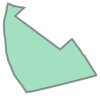

In [4]:
neighborhoods.loc[0, 'geometry']

#### ...and printing it


In [5]:
print(neighborhoods.loc[0, 'geometry'])

MULTIPOLYGON (((-86.79511056795417 36.17575964963348, -86.79403325521203 36.17672381962277, -86.79395847673587 36.17673420120556, -86.79373059621346 36.17641850227536, -86.79345684770965 36.1760073285478, -86.7933653702227 36.17592609720739, -86.79294909679425 36.17527664780614, -86.79276591717007 36.17511962002857, -86.79252941560033 36.17471240878589, -86.79204396927803 36.17393170332863, -86.79167790414918 36.17334940652481, -86.7916936044697 36.17329298843413, -86.79203101691085 36.1731861114189, -86.79474163086816 36.17249213438422, -86.79601903802255 36.17218267273473, -86.79764416397879 36.17179978743778, -86.79830164245051 36.17168336043859, -86.79879977448026 36.17243166386886, -86.79924036890505 36.1729960002125, -86.79949254372757 36.1733962443001, -86.79962585216791 36.17371402180879, -86.79978177579596 36.17412395085653, -86.8000340272343 36.17467828643516, -86.80014485213776 36.17518521060327, -86.80021778306909 36.17542866685226, -86.80031177458922 36.17668510380093, -86

#### Plotting a GeoDataFrame is as easy as calling the GeoPandas .plot() function


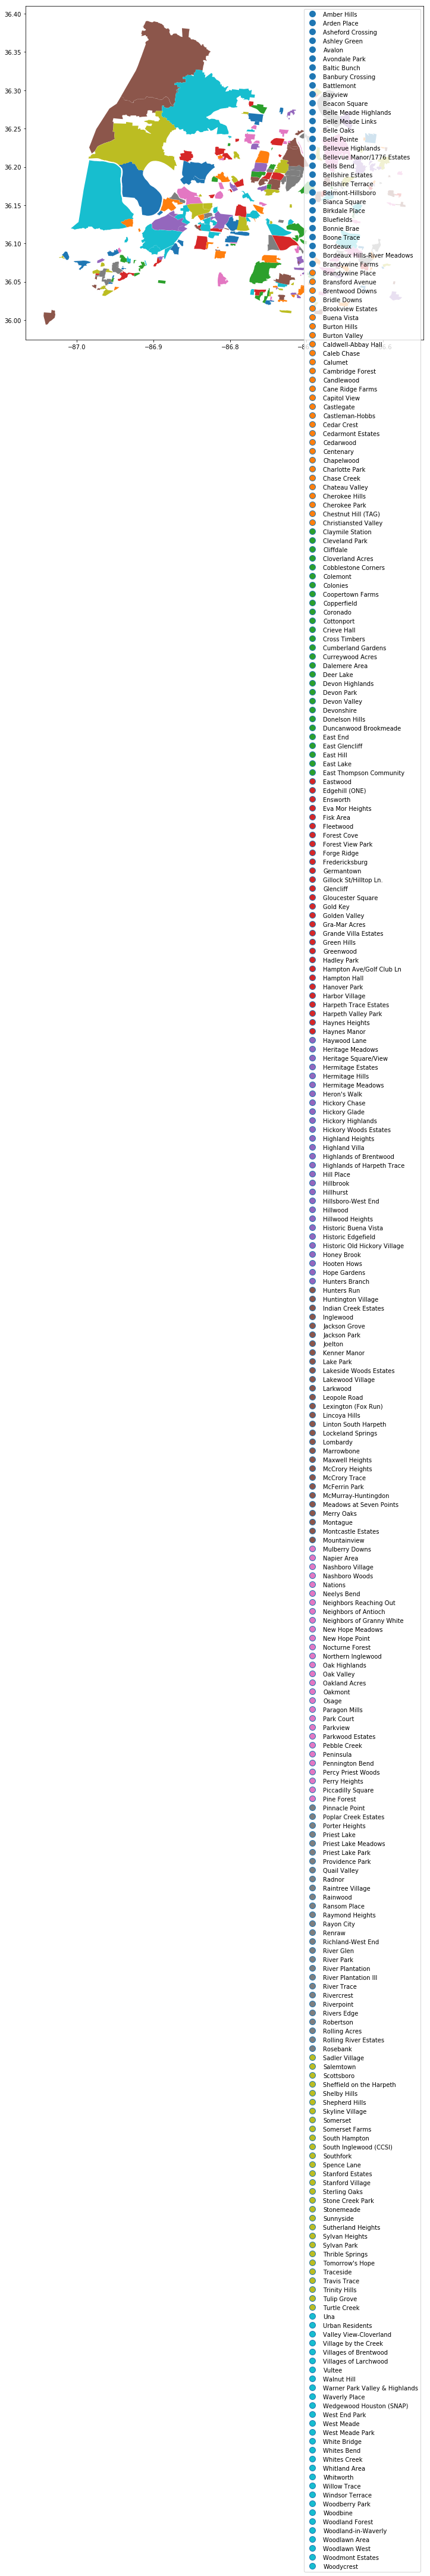

In [6]:
neighborhoods.plot(column = 'name', figsize=(12, 12), legend = True)
plt.show()

#### A little overwhelming...how can we find the neighborhood with the most art? Let's load the public art data and look at the first few rows
https://data.nashville.gov/Art/Art-in-Public-Places/dqkw-tj5j/data

In [7]:
art = pd.read_csv('./data/Art_in_Public_Places__Map_.csv')
art.head()

,Title,Last Name,First Name,Location,Medium,Type,Description,Latitude,Longitude,Mapped Location
0,[Cross Country Runners],Frost,Miley,"4001 Harding Rd., Nashville TN",Bronze,Sculpture,NaN,36.12856,-86.83660,"(36.12856, -86.8366)"
1,[Entry Archway],Unknown,Unknown,"1420 Gallatin Pike South, Madison, TN",Limestone,Sculpture,NaN,36.24126,-86.72559,"(36.24126, -86.72559)"
2,[Fourth and Commerce Sculpture],Walker,Lin,"333 Commerce Street, Nashville TN",NaN,Sculpture,NaN,36.16234,-86.77774,"(36.16234, -86.77774)"
3,[Sculptures on Stone Markers],Billingsley,Cindy,"7311 Hwy 100, Nashville TN",Bronze,Sculpture,NaN,36.06089,-86.91456,"(36.06089, -86.91456)"
4,[Statue of U.S. Colored Troops soldier],Butler,Roy,"1420 Gallatin Pike South, Madison, TN",Bronze,Sculpture,NaN,36.24126,-86.72559,"(36.24126, -86.72559)"


#### We'll clean up the column names so they don't have spaces, and then use a lambda expression with shapely Point to create a geometry field in the art DataFrame

In [8]:
art.columns = ['title', 'last_name', 'first_name', 'address', 'medium', 'type', 'desc', 'lat', 'lng', 'loc']
art['geometry'] = art.apply(lambda x: Point((float(x.lng), float(x.lat))), axis=1)

#### Now that art has a geometry field, we can convert it from a DataFrame to a GeoDataFrame - we want the CRS to match the CRS in the neighborhoods GeoDataFrame so we set it to that

In [9]:
art = gpd.GeoDataFrame(art, crs = neighborhoods.crs, geometry = art['geometry'])

#### Now we're ready to combine the neighborhoods and the art with a spatial join


In [10]:
neighborhood_art = gpd.sjoin(art, neighborhoods, op = 'within')

#### Now that the data is joined spatially we can aggregate the art by neighborhood and see how many artworks are within each polygon

In [12]:
neighborhood_art[['name', 'title']].groupby('name').agg('count').sort_values(by ='title', ascending = False)

,title
name,
Urban Residents,22
Lockeland Springs,3
Edgehill (ONE),2
Germantown,2
Hillsboro-West End,2
Inglewood,2
Sunnyside,2
Chestnut Hill (TAG),1
Historic Edgefield,1


#### We'll subset the neighborhood_art to get only the art that is in the downtown 'Urban Residents' neighborhood

In [14]:
urban_art = neighborhood_art.loc[neighborhood_art.name == 'Urban Residents']
urban_art.head()

,title,last_name,first_name,address,medium,type,desc,lat,lng,loc,geometry,index_right,name
2,[Fourth and Commerce Sculpture],Walker,Lin,"333 Commerce Street, Nashville TN",NaN,Sculpture,NaN,36.16234,-86.77774,"(36.16234, -86.77774)",POINT (-86.77774000000001 36.16234),41,Urban Residents
9,A Story of Nashville,Ridley,Greg,"615 Church Street, Nashville TN",Hammered copper repousse,Frieze,"Inside the Grand Reading Room, this is a serie...",36.16215,-86.78205,"(36.16215, -86.78205)",POINT (-86.78205 36.16215),41,Urban Residents
28,Chet Atkins,Faxon,Russell,"Corner of Fifth Avenue North and Union Street,...",Bronze stool and guitar on a granite plynth,Sculpture,A sculpture of a young Chet Atkins seated on a...,36.16466,-86.78102,"(36.16466, -86.78102)",POINT (-86.78102 36.16466),41,Urban Residents
29,Children's Chairs For The Seasons,McGraw,Deloss,"615 Church Street, Nashville TN",Mixed Media - wood and paint,Furniture,chairs depicting the four seasons,36.16215,-86.78205,"(36.16215, -86.78205)",POINT (-86.78205 36.16215),41,Urban Residents
41,Foliated Scroll,Bloomer,Kent,"615 Church Street, Nashville TN",Aluminum,Frieze,a contemporary adaptation of a classical folia...,36.16215,-86.78205,"(36.16215, -86.78205)",POINT (-86.78205 36.16215),41,Urban Residents


#### Next we'll get just the 'Urban Residents' polygon from the neighborhoods data and take a look at it

In [15]:
urban_polygon = neighborhoods.loc[neighborhoods.name == 'Urban Residents']
urban_polygon.head() 

,name,geometry
index_right,,
41,Urban Residents,(POLYGON ((-86.78122053774267 36.1645653773768...


#### Let's go ahead and plot the Urban Residents Neighborhood and add our public art, coloring the points by the type of art.

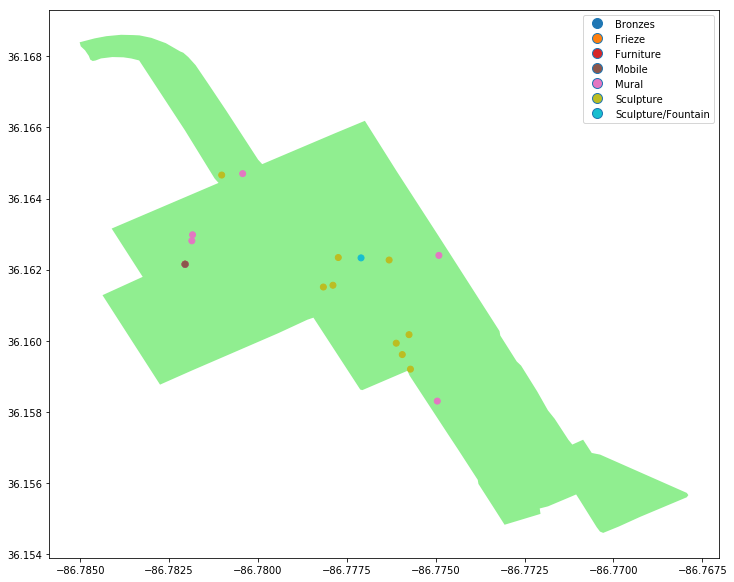

In [16]:
ax = urban_polygon.plot(figsize = (12, 12), color = 'lightgreen')
urban_art.plot( ax = ax, column = 'type', legend = True);
plt.show();

#### We're getting there! It would be helpful to have streets, though wouldn't it? We can add a street map with the folium package.

#### Our folium map wants a center point for the street map. We'll make use of a GeoPandas geometry property (.centroid) which gives us the center of a polygon.

In [17]:
#find the center of our urban_polygon and look at it
urban_polygon.geometry.centroid

index_right
41    POINT (-86.77756457127047 36.16127820928791)
dtype: object

In [18]:
c = urban_polygon.geometry.centroid
c_point = c.iloc[0]
c_location = [c_point.y, c_point.x]

#### We'll copy the longitude and latitude from urban center to the location of our folium map call. A zoom level of 15 should get us nice and close.

In [19]:
#create our map of Nashville and show it
map_downtown = folium.Map(location =  c_location, zoom_start = 15)
map_downtown

#### Next, let's add our Urban Residents neighborhood polygon and art markers.

In [62]:
for (i, row) in enumerate(urban_art.iterrows()):
    row_values = row[1]
    print(row_values)

title              [Fourth and Commerce Sculpture]
last_name                                   Walker
first_name                                     Lin
address          333 Commerce Street, Nashville TN
medium                                         NaN
type                                     Sculpture
desc                                           NaN
lat                                        36.1623
lng                                       -86.7777
loc                          (36.16234, -86.77774)
geometry       POINT (-86.77774000000001 36.16234)
index_right                                     41
name                               Urban Residents
Name: 2, dtype: object
title                                       A Story of Nashville
last_name                                                 Ridley
first_name                                                  Greg
address                          615 Church Street, Nashville TN
medium                                  Hammered coppe

In [23]:
#draw our neighborhood: Urban Residents
folium.GeoJson(urban_polygon).add_to(map_downtown)

#iterate through our urban art to create markers for each piece
#here lat is listed first!!
#also the apostrophe in the 4th row causes problems!

p_title = str(row_values['title'])
p_type = str(row_values['type'])
p_desc = str(row_values['desc'])

for (i, row) in enumerate(urban_art.iterrows()):
    row_values = row[1] 
    location = [row_values['lat'], row_values['lng']]
    popup = ('<strong>' + p_title + ': ' + p_type + '</strong>' + '<br>' + p_desc).replace("'", "`")
    #popup = "there's a quote in this" + str(row_values['type'])
    marker = folium.Marker(location = location, popup = popup)
    
    marker.add_to(map_downtown)

#display our map
map_downtown